<a href="https://colab.research.google.com/github/r-nassib/Text-Mining/blob/main/Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# Install the Weights & Biases library
!pip install wandb sentence-transformers --upgrade

In [17]:
# 1. Importaciones
import os
import re
import wandb
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report
)

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

wandb.login()

run = wandb.init(
    project="fakeNewsDetection",
    entity="rhidalgou2-universidad-de-granada",
    job_type="create_raw_artifacts"
)

# Creamos artifact para True
true_artifact = wandb.Artifact(
    name="true_raw",
    type="dataset",
    description="Noticias reales (True.csv)"
)

# Subir dataset True.csv a Colab en el directorio /content/
true_artifact.add_file("True.csv")
wandb.log_artifact(true_artifact)

# Creamos artifact para Fake
fake_artifact = wandb.Artifact(
    name="fake_raw",
    type="dataset",
    description="Noticias falsas (Fake.csv)"
)

# Subir dataset Fake.csv a Colab en el directorio /content/
fake_artifact.add_file("Fake.csv")
wandb.log_artifact(fake_artifact)

run.finish()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [18]:
wandb.login()

run = wandb.init(
    project="fakeNewsDetection",
    entity="rhidalgou2-universidad-de-granada",
    job_type="nlp_training"
)

config = wandb.config
config.max_features = 10000
config.test_size = 0.2
config.random_state = 42


In [19]:
# TRUE
true_artifact = run.use_artifact("true_raw:latest")
true_dir = true_artifact.download()
true_path = os.path.join(true_dir, "True.csv")  # mismo nombre que el archivo original
print("TRUE path:", true_path)

# FAKE
fake_artifact = run.use_artifact("fake_raw:latest")
fake_dir = fake_artifact.download()
fake_path = os.path.join(fake_dir, "Fake.csv")
print("FAKE path:", fake_path)

df_true = pd.read_csv(true_path, on_bad_lines='skip', engine='python')
df_fake = pd.read_csv(fake_path, on_bad_lines='skip', engine='python')

df_true["label"] = 1  # real
df_fake["label"] = 0  # fake

df = pd.concat([df_true, df_fake], ignore_index=True)

# Combinar título + texto
df["full_text"] = df["title"].fillna("") + " " + df["text"].fillna("")
df = df[["full_text", "text", "title", "subject", "date", "label"]]

print(df.head())
print(df["label"].value_counts())

wandb:   1 of 1 files downloaded.  


TRUE path: /content/artifacts/true_raw:v0/True.csv


wandb:   1 of 1 files downloaded.  


FAKE path: /content/artifacts/fake_raw:v0/Fake.csv
                                           full_text  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text  \
0  WASHINGTON (Reuters) - The head of a conservat...   
1  WASHINGTON (Reuters) - Transgender people will...   
2  WASHINGTON (Reuters) - The special counsel inv...   
3  WASHINGTON (Reuters) - Trump campaign adviser ...   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...   

                                               title       subject  \
0  As U.S. budget fight looms, Republicans flip t...  politicsNews   
1  U.S. military to accept transgender recruits o...  politicsNews   
2  Senior U.S. Republican senator: 'Let Mr. Muell...  politicsNew

Shape: (14536, 6)

Distribución de clases:
 label
real    7583
fake    6953
Name: count, dtype: int64

Estadísticas de longitud de texto:
count    14536.000000
mean       428.199849
std        233.593087
min         29.000000
25%        316.000000
50%        406.000000
75%        532.000000
max       5181.000000
Name: text_len, dtype: float64


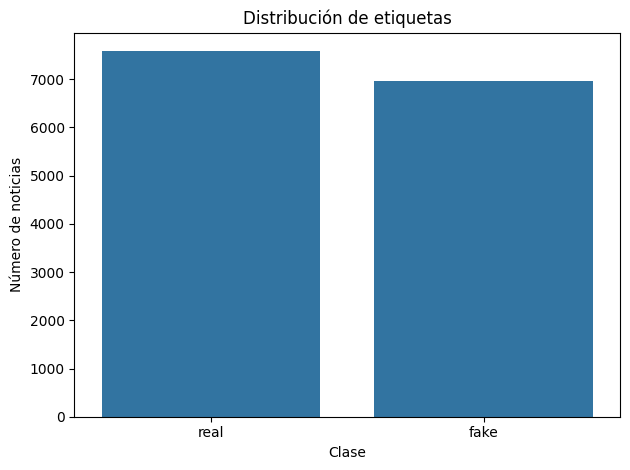

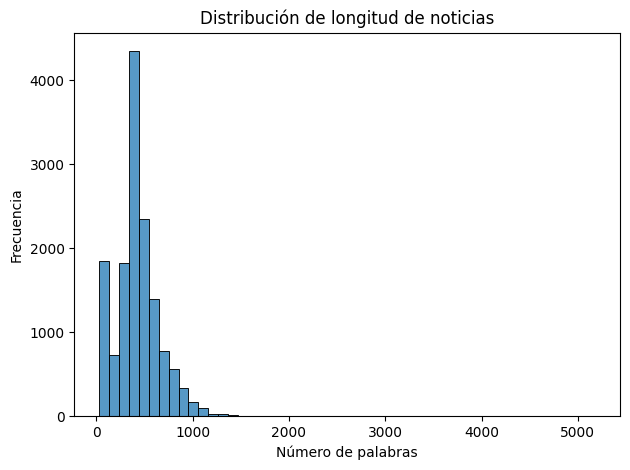

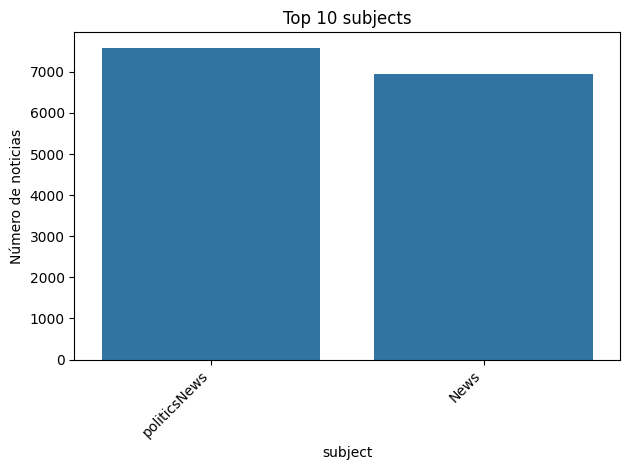

In [20]:
print("Shape:", df.shape)

# Distribución clases
label_counts = df["label"].value_counts().rename(index={0: "fake", 1: "real"})
print("\nDistribución de clases:\n", label_counts)

df["text_len"] = df["full_text"].str.split().apply(len)
print("\nEstadísticas de longitud de texto:")
print(df["text_len"].describe())

wandb.log({
    "num_samples": len(df),
    "num_fake": int((df["label"] == 0).sum()),
    "num_real": int((df["label"] == 1).sum()),
    "text_length_mean": df["text_len"].mean()
})

# Plot 1: distribución de labels
plt.figure()
sns.countplot(x=df["label"].map({0: "fake", 1: "real"}))
plt.title("Distribución de etiquetas")
plt.xlabel("Clase")
plt.ylabel("Número de noticias")
plt.tight_layout()
plt.show()

# Plot 2: histograma de longitudes
plt.figure()
sns.histplot(df["text_len"], bins=50)
plt.title("Distribución de longitud de noticias")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# Plot 3: top subjects
plt.figure()
subject_counts = df["subject"].value_counts().head(10)
sns.barplot(x=subject_counts.index, y=subject_counts.values)
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 subjects")
plt.ylabel("Número de noticias")
plt.tight_layout()
plt.show()

In [21]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)        # quitar URLs
    text = re.sub(r'[^a-z\s]', '', text)       # dejar solo letras y espacios
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return " ".join(tokens)

df["clean_text"] = df["full_text"].apply(clean_text)

df[["full_text", "clean_text"]].head()

,full_text,clean_text
0,"As U.S. budget fight looms, Republicans flip t...",u budget fight loom republican flip fiscal scr...
1,U.S. military to accept transgender recruits o...,u military accept transgender recruit monday p...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,senior u republican senator let mr mueller job...
3,FBI Russia probe helped by Australian diplomat...,fbi russia probe helped australian diplomat ti...
4,Trump wants Postal Service to charge 'much mor...,trump want postal service charge much amazon s...


In [22]:
X_text = df["clean_text"].values
y = df["label"].values

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y,
    test_size=config.test_size,
    stratify=y,
    random_state=config.random_state
)

tfidf = TfidfVectorizer(max_features=config.max_features)
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf  = tfidf.transform(X_test_text)

X_train_tfidf.shape, X_test_tfidf.shape

((11628, 10000), (2908, 10000))

In [23]:
clf = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",   # por si hay desbalance
    n_jobs=-1
)

clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(X_test_tfidf)


TFIDF - Accuracy : 0.9927785419532325
TFIDF - F1-score : 0.9930989155438712
TFIDF - Precision: 0.990170380078637
TFIDF - Recall   : 0.996044825313118

Classification report:

              precision    recall  f1-score   support

        fake       1.00      0.99      0.99      1391
        real       0.99      1.00      0.99      1517

    accuracy                           0.99      2908
   macro avg       0.99      0.99      0.99      2908
weighted avg       0.99      0.99      0.99      2908



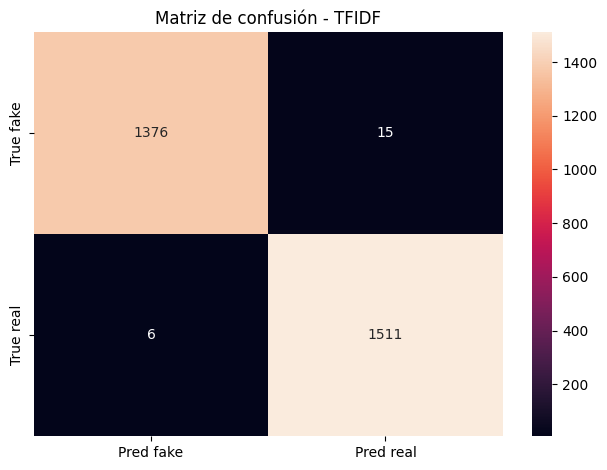

num_fake,▁
num_real,▁
num_samples,▁
text_length_mean,▁
tfidf_accuracy,▁
tfidf_f1,▁
tfidf_precision,▁
tfidf_recall,▁
num_fake,6953
num_real,7583
num_samples,14536


In [24]:
# Métricas y matriz de confusión

acc  = accuracy_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)

print("TFIDF - Accuracy :", acc)
print("TFIDF - F1-score :", f1)
print("TFIDF - Precision:", prec)
print("TFIDF - Recall   :", rec)

print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=["fake", "real"]))

cm = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Pred fake", "Pred real"],
            yticklabels=["True fake", "True real"])
plt.title("Matriz de confusión - TFIDF")
plt.tight_layout()
plt.show()

wandb.log({
    "tfidf_accuracy": acc,
    "tfidf_f1": f1,
    "tfidf_precision": prec,
    "tfidf_recall": rec,
})

# Guardar el modelo y el vectorizador como Artifact de modelo
import joblib

os.makedirs("models", exist_ok=True)
joblib.dump(clf, "models/fake_news_tfidf_logreg.pkl")
joblib.dump(tfidf, "models/tfidf_vectorizer.pkl")

model_artifact = wandb.Artifact(
    "fake_news_tfidf_logreg",
    type="model",
    description="Modelo TF-IDF + Logistic Regression para clasificación fake/real"
)
model_artifact.add_file("models/fake_news_tfidf_logreg.pkl")
model_artifact.add_file("models/tfidf_vectorizer.pkl")

wandb.log_artifact(model_artifact)

run.finish()